In [54]:
# normal imports
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# ANN imports
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop

# sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# set random state to use throughout
rs = 25

In [2]:
# code to return train/test values using categorical data
def trainTestCategorical(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(),
        test_size=0.2, random_state=rs)
    # set categorical targets formatted for ANN: one column per class
    yc_train = pd.get_dummies(y_train).as_matrix()
    yc_test = pd.get_dummies(y_test).as_matrix()
    # set categorical targets formatted for other models using Label Encoder
    le = LabelEncoder()
    ye_train = le.fit_transform(y_train)
    ye_test = le.transform(y_test)
    return X_train, X_test, yc_train, yc_test, ye_train, ye_test, le

In [16]:
# function specifying layers of ANN model
def doSequentialModel(dim_input, dim_output):
    model = Sequential()

    model.add(Dense(32, input_dim=dim_input, activation = 'tanh'))
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.25))

    model.add(Dense(dim_output, activation='softmax'))

    sgd = SGD(lr = .05)
    model.compile(optimizer = sgd, loss = 'mse', metrics = ['accuracy'])
    
    return model

In [17]:
# function to create and fit ANN
def createFitANN(X_train, y_train):
    model = doSequentialModel(X_train.shape[1],y_train.shape[1])
    model.fit(X_train, y_train, nb_epoch = 20, batch_size = 100)
    return model

In [5]:
def evalClassifier(y_true, y_pred):
    print 'confusion matrix \n', confusion_matrix(y_true, y_pred)
    print 'classification report \n', classification_report(y_true, y_pred)
    print 'accuracy score \n', accuracy_score(y_true, y_pred)

In [6]:
def fitEvalRFClassifier(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_jobs=-1,random_state=rs)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    evalClassifier(y_test, rf_pred)

In [34]:
# import data and format it
data = pd.read_csv('../Data/gss_subset_cleaned.csv')
data = data[data['year']> 2005]
data.drop(['paeduc', 'maeduc', 'speduc', 'income', 'satjob', 'goodlife','health', 'year'], axis=1, inplace=True)
# for initial model, just drop all na
data.dropna(inplace=True)

Index([u'marital', u'divorce', u'sibs', u'childs', u'age', u'educ', u'sex',
       u'hompop', u'babies', u'preteen', u'teens', u'adults', u'earnrs',
       u'polviews', u'happy', u'weekswrk', u'satfin', u'dwelling', u'dwelown',
       u'hhrace'],
      dtype='object')

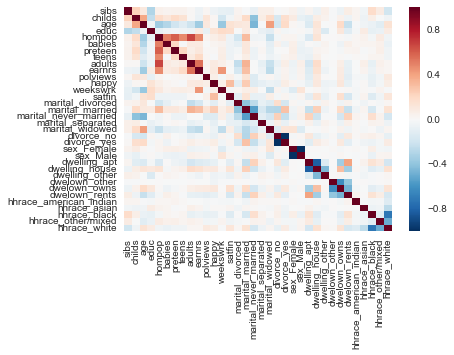

In [55]:
# look at correlations
corrs = pd.get_dummies(data).corr()
sns.heatmap(corrs)

In [79]:
corrs = pd.get_dummies(data).corr()
highcorrs = []
for col in corrs:
    for ind in corrs.index:
        if col < ind:
            corr = corrs.loc[ind, col]
            if corr > 0.5:
                highcorrs.append((ind, col, corr))
for line in highcorrs: print line

('preteen', 'hompop', 0.5939648059323408)
('hompop', 'babies', 0.5057623540449554)
('hompop', 'adults', 0.67807785850439251)
('earnrs', 'adults', 0.55293844588911512)


In [80]:
# remove hompop and earnrs because of high correlations with other features
del data['hompop']
del data['earnrs']

# ANN and RF for predicting happy vs unhappy

In [81]:
# set target and columns to exclude
target = 'happy'
exclude_cols = []
exclude_cols.append(target)

# X, y
y = data[target] > 1
X = pd.get_dummies(data.drop(exclude_cols, axis=1), drop_first=True)

# check the ratio of target values: determine threshold for beating guessing
(data[target].value_counts()/data[target].count()).sort_index()

1.0    0.142291
2.0    0.559948
3.0    0.297761
Name: happy, dtype: float64

In [82]:
# do train test split
X_train, X_test, yc_train, yc_test, ye_train, ye_test, le = trainTestCategorical(X, y)

In [83]:
# fit and evaluate ANN model
model = createFitANN(X_train, yc_train)
print 'testing set evaluation'
model.evaluate(X_test, yc_test)

Epoch 1/20
8680/8680 [==============================] - 0s - loss: 0.1337 - acc: 0.8474     
Epoch 2/20
8680/8680 [==============================] - 0s - loss: 0.1288 - acc: 0.8563     
Epoch 3/20
8680/8680 [==============================] - 0s - loss: 0.1269 - acc: 0.8578     
Epoch 4/20
8680/8680 [==============================] - 0s - loss: 0.1262 - acc: 0.8579     
Epoch 5/20
8680/8680 [==============================] - 0s - loss: 0.1253 - acc: 0.8584     
Epoch 6/20
8680/8680 [==============================] - 0s - loss: 0.1241 - acc: 0.8586     
Epoch 7/20
8680/8680 [==============================] - 0s - loss: 0.1240 - acc: 0.8584     
Epoch 8/20
8680/8680 [==============================] - 0s - loss: 0.1237 - acc: 0.8585     
Epoch 9/20
8680/8680 [==============================] - 0s - loss: 0.1243 - acc: 0.8586     
Epoch 10/20
8680/8680 [==============================] - 0s - loss: 0.1234 - acc: 0.8585     
Epoch 11/20
8680/8680 [==============================] - 0s - loss: 0

[0.121750116337971, 0.85444495604917892]

In [84]:
# compare with Random Forest model
fitEvalRFClassifier(X_train, X_test, ye_train, ye_test)

confusion matrix 
[[  55  261]
 [  90 1765]]
classification report 
             precision    recall  f1-score   support

          0       0.38      0.17      0.24       316
          1       0.87      0.95      0.91      1855

avg / total       0.80      0.84      0.81      2171

accuracy score 
0.838323353293


# ANN and RF for predicting marital status

In [85]:
# set target and columns to exclude
target = 'marital'
exclude_cols = ['divorce'] #including divorce status would be cheating..!
exclude_cols.append(target)

# X, y
y = data[target]
X = pd.get_dummies(data.drop(exclude_cols, axis=1), drop_first=True)

# check the ratio of target values: determine threshold for beating guessing
(data[target].value_counts()/data[target].count()).sort_index()

divorced         0.161183
married          0.460787
never_married    0.260621
separated        0.032532
widowed          0.084877
Name: marital, dtype: float64

In [86]:
# do train test split
X_train, X_test, yc_train, yc_test, ye_train, ye_test, le = trainTestCategorical(X, y)

In [87]:
# fit and evaluate ANN model
model = createFitANN(X_train, yc_train)
print 'testing set evaluation'
model.evaluate(X_test, yc_test)

Epoch 1/20
8680/8680 [==============================] - 0s - loss: 0.1606 - acc: 0.3445     
Epoch 2/20
8680/8680 [==============================] - 0s - loss: 0.1475 - acc: 0.4025     
Epoch 3/20
8680/8680 [==============================] - 0s - loss: 0.1435 - acc: 0.4177     
Epoch 4/20
8680/8680 [==============================] - 0s - loss: 0.1419 - acc: 0.4251     
Epoch 5/20
8680/8680 [==============================] - 0s - loss: 0.1410 - acc: 0.4369     
Epoch 6/20
8680/8680 [==============================] - 0s - loss: 0.1387 - acc: 0.4493     
Epoch 7/20
8680/8680 [==============================] - 0s - loss: 0.1374 - acc: 0.4627     
Epoch 8/20
8680/8680 [==============================] - 0s - loss: 0.1365 - acc: 0.4668     
Epoch 9/20
8680/8680 [==============================] - 0s - loss: 0.1362 - acc: 0.4734     
Epoch 10/20
8680/8680 [==============================] - 0s - loss: 0.1351 - acc: 0.4785     
Epoch 11/20
8680/8680 [==============================] - 0s - loss: 0

[0.1297228650144035, 0.48917549528706628]

In [88]:
# compare with Random Forest model
fitEvalRFClassifier(X_train, X_test, ye_train, ye_test)

confusion matrix 
[[163 100  70   3  40]
 [ 35 854  66   1   6]
 [ 50  92 410   3   5]
 [ 30  23  22   2   7]
 [ 49  31  12   2  95]]
classification report 
             precision    recall  f1-score   support

          0       0.50      0.43      0.46       376
          1       0.78      0.89      0.83       962
          2       0.71      0.73      0.72       560
          3       0.18      0.02      0.04        84
          4       0.62      0.50      0.56       189

avg / total       0.67      0.70      0.68      2171

accuracy score 
0.701980654076


# ANN and RF for predicting gender

In [89]:
# set target and columns to exclude
target = 'sex'
exclude_cols = []
exclude_cols.append(target)

# X, y
y = data[target]
X = pd.get_dummies(data.drop(exclude_cols, axis=1), drop_first=True)

# check the ratio of target values: determine threshold for beating guessing
(data[target].value_counts()/data[target].count()).sort_index()

Female    0.553405
Male      0.446595
Name: sex, dtype: float64

In [90]:
# do train test split
X_train, X_test, yc_train, yc_test, ye_train, ye_test, le = trainTestCategorical(X, y)

# fit and evaluate ANN model
model = createFitANN(X_train, yc_train)
print 'testing set evaluation'
model.evaluate(X_test, yc_test)

Epoch 1/20
8680/8680 [==============================] - 0s - loss: 0.2731 - acc: 0.5327     
Epoch 2/20
8680/8680 [==============================] - 0s - loss: 0.2553 - acc: 0.5387     
Epoch 3/20
8680/8680 [==============================] - 0s - loss: 0.2501 - acc: 0.5444     
Epoch 4/20
8680/8680 [==============================] - 0s - loss: 0.2478 - acc: 0.5468     
Epoch 5/20
8680/8680 [==============================] - 0s - loss: 0.2467 - acc: 0.5480     
Epoch 6/20
8680/8680 [==============================] - 0s - loss: 0.2468 - acc: 0.5492     
Epoch 7/20
8680/8680 [==============================] - 0s - loss: 0.2451 - acc: 0.5486     
Epoch 8/20
8680/8680 [==============================] - 0s - loss: 0.2456 - acc: 0.5568     
Epoch 9/20
8680/8680 [==============================] - 0s - loss: 0.2453 - acc: 0.5563     
Epoch 10/20
8680/8680 [==============================] - 0s - loss: 0.2444 - acc: 0.5551     
Epoch 11/20
8680/8680 [==============================] - 0s - loss: 0

[0.24450036793439303, 0.53892215593571713]

In [91]:
# compare with Random Forest model
fitEvalRFClassifier(X_train, X_test, ye_train, ye_test)

confusion matrix 
[[875 293]
 [580 423]]
classification report 
             precision    recall  f1-score   support

          0       0.60      0.75      0.67      1168
          1       0.59      0.42      0.49      1003

avg / total       0.60      0.60      0.59      2171

accuracy score 
0.597881160755


# ANN and RF for predicting home ownership/rental/other status

In [92]:
# set target and columns to exclude
target = 'dwelown'
exclude_cols = []
exclude_cols.append(target)

# X, y
y = data[target]
X = pd.get_dummies(data.drop(exclude_cols, axis=1), drop_first=True)

# check the ratio of target values: determine threshold for beating guessing
(data[target].value_counts()/data[target].count()).sort_index()

other    0.343931
owns     0.427057
rents    0.229011
Name: dwelown, dtype: float64

In [93]:
# do train test split
X_train, X_test, yc_train, yc_test, ye_train, ye_test, le = trainTestCategorical(X, y)

# fit and evaluate ANN model
model = createFitANN(X_train, yc_train)
print 'testing set evaluation'
model.evaluate(X_test, yc_test)

Epoch 1/20
8680/8680 [==============================] - 0s - loss: 0.2369 - acc: 0.3930     
Epoch 2/20
8680/8680 [==============================] - 0s - loss: 0.2279 - acc: 0.4091     
Epoch 3/20
8680/8680 [==============================] - 0s - loss: 0.2225 - acc: 0.4094     
Epoch 4/20
8680/8680 [==============================] - 0s - loss: 0.2204 - acc: 0.4187     
Epoch 5/20
8680/8680 [==============================] - 0s - loss: 0.2178 - acc: 0.4190     
Epoch 6/20
8680/8680 [==============================] - 0s - loss: 0.2162 - acc: 0.4197     
Epoch 7/20
8680/8680 [==============================] - 0s - loss: 0.2159 - acc: 0.4266     
Epoch 8/20
8680/8680 [==============================] - 0s - loss: 0.2153 - acc: 0.4321     
Epoch 9/20
8680/8680 [==============================] - 0s - loss: 0.2151 - acc: 0.4308     
Epoch 10/20
8680/8680 [==============================] - 0s - loss: 0.2127 - acc: 0.4388     
Epoch 11/20
8680/8680 [==============================] - 0s - loss: 0

[0.21078934275104613, 0.43021649013791202]

In [94]:
# compare with Random Forest model
fitEvalRFClassifier(X_train, X_test, ye_train, ye_test)

confusion matrix 
[[283 332 150]
 [301 514  66]
 [189 122 214]]
classification report 
             precision    recall  f1-score   support

          0       0.37      0.37      0.37       765
          1       0.53      0.58      0.56       881
          2       0.50      0.41      0.45       525

avg / total       0.46      0.47      0.46      2171

accuracy score 
0.465684016582


# ANN and RF for predicting whether or not person has children

In [95]:
# set target and columns to exclude
target = 'childs'
exclude_cols = ['babies','preteen','teens']
exclude_cols.append(target)

# X, y
y = data[target] >0
X = pd.get_dummies(data.drop(exclude_cols, axis=1), drop_first=True)

# check the ratio of target values: determine threshold for beating guessing
(data[target].value_counts()/data[target].count()).sort_index()

0.0    0.272233
1.0    0.154917
2.0    0.263662
3.0    0.160630
4.0    0.080546
5.0    0.033545
6.0    0.016865
7.0    0.007926
8.0    0.009677
Name: childs, dtype: float64

In [96]:
# do train test split
X_train, X_test, yc_train, yc_test, ye_train, ye_test, le = trainTestCategorical(X, y)

# fit and evaluate ANN model
model = createFitANN(X_train, yc_train)
print 'testing set evaluation'
model.evaluate(X_test, yc_test)

Epoch 1/20
8680/8680 [==============================] - 0s - loss: 0.2101 - acc: 0.7116     
Epoch 2/20
8680/8680 [==============================] - 0s - loss: 0.1918 - acc: 0.7366     
Epoch 3/20
8680/8680 [==============================] - 0s - loss: 0.1777 - acc: 0.7531     
Epoch 4/20
8680/8680 [==============================] - 0s - loss: 0.1757 - acc: 0.7605     
Epoch 5/20
8680/8680 [==============================] - 0s - loss: 0.1710 - acc: 0.7730     
Epoch 6/20
8680/8680 [==============================] - 0s - loss: 0.1718 - acc: 0.7672     
Epoch 7/20
8680/8680 [==============================] - 0s - loss: 0.1684 - acc: 0.7801     
Epoch 8/20
8680/8680 [==============================] - 0s - loss: 0.1676 - acc: 0.7779     
Epoch 9/20
8680/8680 [==============================] - 0s - loss: 0.1643 - acc: 0.7823     
Epoch 10/20
8680/8680 [==============================] - 0s - loss: 0.1669 - acc: 0.7811     
Epoch 11/20
8680/8680 [==============================] - 0s - loss: 0

[0.15567635761626247, 0.78857669246630535]

In [97]:
# compare with Random Forest model
fitEvalRFClassifier(X_train, X_test, ye_train, ye_test)

confusion matrix 
[[ 359  232]
 [ 146 1434]]
classification report 
             precision    recall  f1-score   support

          0       0.71      0.61      0.66       591
          1       0.86      0.91      0.88      1580

avg / total       0.82      0.83      0.82      2171

accuracy score 
0.825886688162
